# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [ ]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [ ]:
!pip -q install git+https://github.com/tensorflow/privacy

     |████████████████████████████████| 194kB 8.2MB/s 


##### Import libraries

In [ ]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleAttackResult
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [ ]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:05, 141MB/s]


##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [256, 256, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [ ]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [ ]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [ ]:
# create train-val-test split with 80-5-15
x_train, x_rest, y_train, y_rest = train_test_split(files, labels, test_size=VAL_SPLIT+TEST_SPLIT, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT), random_state=random_state)

In [ ]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7232, Val: 452, Test: 1356


In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4339, 'COVID-19': 2893}
val set:  {'normal': 272, 'COVID-19': 180}
test set:   {'normal': 813, 'COVID-19': 543}


###### Create tensors

In [ ]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [ ]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [ ]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [ ]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [ ]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [ ]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [ ]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [ ]:
# set for attack on train set
train_attack_data = prepare_dataset(train_ds,
                                    pre=True,
                                    shuffle=True,
                                    repeat=False,
                                    batch=1,
                                    augment=False,
                                    cache=False)

# set for attack on test set
test_attack_data = prepare_dataset(test_ds,
                                   pre=True,
                                   shuffle=False,
                                   repeat=False,
                                   batch=1,
                                   augment=False,
                                   cache=False)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

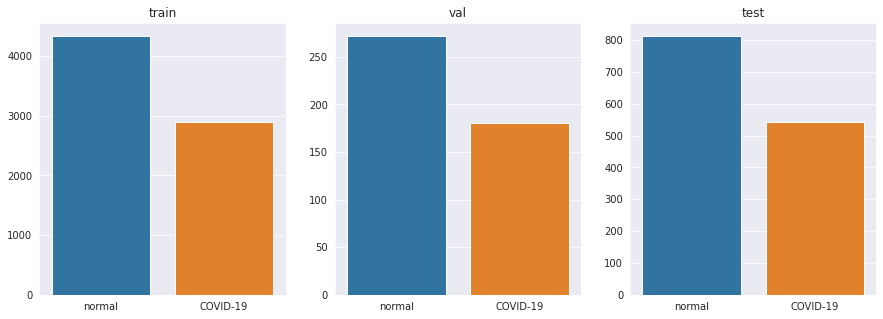

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


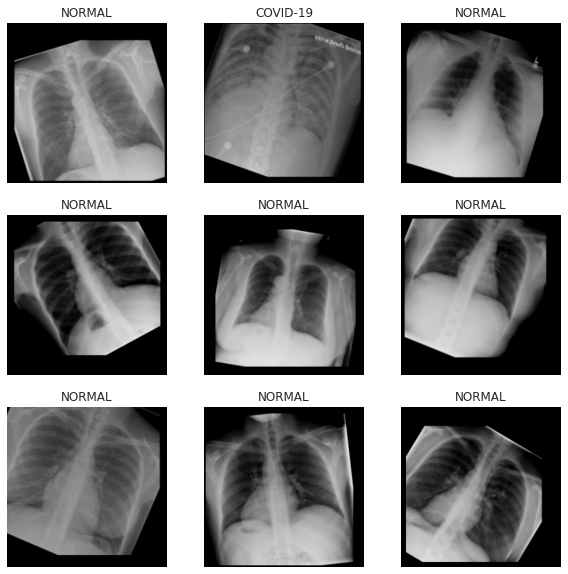

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## ResNet50V2
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
def resnet50_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet50 = ResNet50V2(include_top = False,
                          weights = 'imagenet',
                          input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),)
    
    # make layers trainable
    resnet50.trainable = True
    
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet50, # add pretrained resnet layers to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet50V2')
    
    return model

In [ ]:
resnet50 = resnet50_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
resnet50.summary()

Model: "ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 8, 8, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
history_resnet50 = resnet50.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
226/226 [==============================] - 138s 472ms/step - loss: 0.4975 - accuracy: 0.7756 - precision: 0.7078 - recall: 0.7670 - val_loss: 4.0228 - val_accuracy: 0.6228 - val_precision: 0.8000 - val_recall: 0.0674
Epoch 2/20
226/226 [==============================] - 99s 438ms/step - loss: 0.2912 - accuracy: 0.8776 - precision: 0.8331 - recall: 0.8759 - val_loss: 2.6100 - val_accuracy: 0.6228 - val_precision: 0.5251 - val_recall: 0.5281
Epoch 3/20
226/226 [==============================] - 99s 441ms/step - loss: 0.2309 - accuracy: 0.9117 - precision: 0.8807 - recall: 0.9065 - val_loss: 0.5831 - val_accuracy: 0.6183 - val_precision: 1.0000 - val_recall: 0.0393
Epoch 4/20
226/226 [==============================] - 99s 439ms/step - loss: 0.2333 - accuracy: 0.9035 - precision: 0.8659 - recall: 0.9036 - val_loss: 0.7735 - val_accuracy: 0.660

### Evaluation

###### Visualize performance

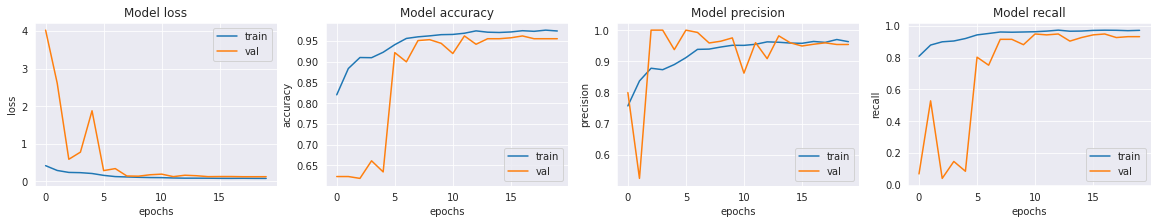

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet50.history[met])
    ax[i].plot(history_resnet50.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 4s 86ms/step - loss: 0.1052 - accuracy: 0.9624 - precision: 0.9457 - recall: 0.9613
Loss of the model is -  0.10520599782466888
Accuracy of the model is -  96.23894095420837 %
Precision of the model is -  0.945652186870575
Recall of the model is -  0.9613259434700012


## ResNet50V2 - low lr
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
def resnet50_lr_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet50 = ResNet50V2(include_top = False,
                          weights = 'imagenet',
                          input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),)
    
    # make layers trainable
    resnet50.trainable = True
    
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet50, # add pretrained resnet layers to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet50V2-lr')
    
    return model

In [ ]:
resnet50_lr = resnet50_lr_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50_lr.compile(
    # very low learning rate to adapt pretrained weights to new data without
    # overfitting from small dataset
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
resnet50_lr.summary()

Model: "ResNet50V2-lr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_7 (ModuleWrap (None, 8, 8, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
history_resnet50_lr = resnet50_lr.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
226/226 [==============================] - 107s 444ms/step - loss: 0.5547 - accuracy: 0.7266 - precision: 0.7016 - recall: 0.5400 - val_loss: 0.3665 - val_accuracy: 0.8795 - val_precision: 0.8780 - val_recall: 0.8090
Epoch 2/20
226/226 [==============================] - 98s 436ms/step - loss: 0.2283 - accuracy: 0.9120 - precision: 0.8861 - recall: 0.8942 - val_loss: 0.2709 - val_accuracy: 0.9174 - val_precision: 0.8615 - val_recall: 0.9438
Epoch 3/20
226/226 [==============================] - 99s 438ms/step - loss: 0.1724 - accuracy: 0.9355 - precision: 0.9205 - recall: 0.9201 - val_loss: 0.1603 - val_accuracy: 0.9509 - val_precision: 0.9333 - val_recall: 0.9438
Epoch 4/20
226/226 [==============================] - 99s 439ms/step - loss: 0.1262 - accuracy: 0.9561 - precision: 0.9441 - recall: 0.9468 - val_loss: 0.1258 - val_accuracy: 0.9665 - val_precision: 0.9880 - val_recall: 0.9270
Epoch 5/20
226/226 [==============================] - 99s 440ms/step - loss: 0.1182 - accur

### Evaluation

###### Visualize performance

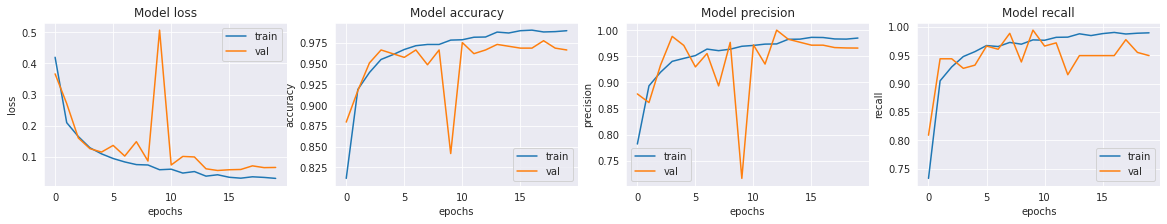

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet50_lr.history[met])
    ax[i].plot(history_resnet50_lr.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50_lr.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 64ms/step - loss: 0.0511 - accuracy: 0.9860 - precision: 0.9852 - recall: 0.9797
Loss of the model is -  0.05110735446214676
Accuracy of the model is -  98.5988199710846 %
Precision of the model is -  0.9851852059364319
Recall of the model is -  0.979742169380188


## ResNet50V2 - no imagenet
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
def resnet50_noimgnet_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet50 = ResNet50V2(include_top = False,
                          weights = None,
                          input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),)
    
    # make layers trainable
    resnet50.trainable = True
    
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet50, # add pretrained resnet layers to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet50V2-noimgnet')
    
    return model

In [ ]:
resnet50_noimgnet = resnet50_noimgnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50_noimgnet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
resnet50_noimgnet.summary()

Model: "ResNet50V2-noimgnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_8 (ModuleWrap (None, 8, 8, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
history_resnet50_noimgnet = resnet50_noimgnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
226/226 [==============================] - 107s 447ms/step - loss: 0.6258 - accuracy: 0.6922 - precision: 0.6099 - recall: 0.6899 - val_loss: 66.4391 - val_accuracy: 0.3951 - val_precision: 0.3960 - val_recall: 0.9944
Epoch 2/20
226/226 [==============================] - 100s 442ms/step - loss: 0.4877 - accuracy: 0.7652 - precision: 0.6860 - recall: 0.7825 - val_loss: 71.0314 - val_accuracy: 0.3973 - val_precision: 0.3973 - val_recall: 1.0000
Epoch 3/20
226/226 [==============================] - 99s 437ms/step - loss: 0.4627 - accuracy: 0.7725 - precision: 0.6811 - recall: 0.8235 - val_loss: 0.8754 - val_accuracy: 0.6786 - val_precision: 0.5966 - val_recall: 0.5899
Epoch 4/20
226/226 [==============================] - 98s 436ms/step - loss: 0.4115 - accuracy: 0.8010 - precision: 0.7196 - recall: 0.8294 - val_loss: 5.6435 - val_accuracy: 0.3795 - val_precision: 0.3571 - val_recall: 0.7022
Epoch 5/20
226/226 [==============================] - 99s 437ms/step - loss: 0.4067 - ac

### Evaluation

###### Visualize performance

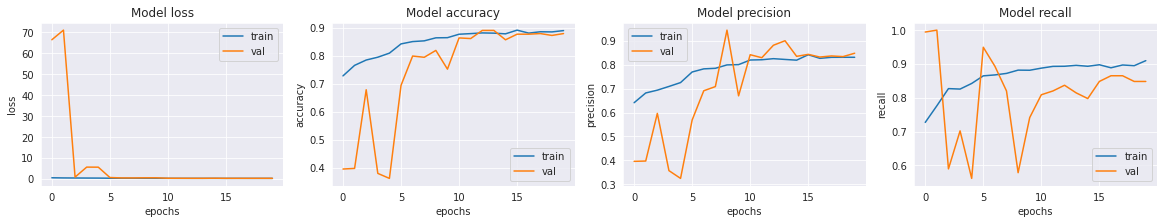

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet50_noimgnet.history[met])
    ax[i].plot(history_resnet50_noimgnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50_noimgnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 65ms/step - loss: 0.2188 - accuracy: 0.9130 - precision: 0.9002 - recall: 0.8803
Loss of the model is -  0.2188478261232376
Accuracy of the model is -  91.29793643951416 %
Precision of the model is -  0.9001883268356323
Recall of the model is -  0.880294680595398


## ResNet50V2 - pneu
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
def resnet50_pneu_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet50 = ResNet50V2(include_top = False,
                          weights = None,
                          input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),)
    
    # make layers trainable
    resnet50.trainable = True
    
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet50, # add pretrained resnet layers to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet50V2-pneu')
    
    return model

In [ ]:
resnet50_pneu = resnet50_pneu_builder()

# load weights from pneumonia pretraining
resnet50_pneu.load_weights(weights_path+'resnet50_relu_public_weights.h5')

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50_pneu.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
resnet50_pneu.summary()

Model: "ResNet50V2-pneu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_9 (ModuleWrap (None, 8, 8, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
history_resnet50_pneu = resnet50_pneu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
226/226 [==============================] - 108s 448ms/step - loss: 0.5831 - accuracy: 0.7075 - precision: 0.6174 - recall: 0.7329 - val_loss: 125.4736 - val_accuracy: 0.3973 - val_precision: 0.3973 - val_recall: 1.0000
Epoch 2/20
226/226 [==============================] - 98s 435ms/step - loss: 0.4920 - accuracy: 0.7513 - precision: 0.6646 - recall: 0.7805 - val_loss: 8.7508 - val_accuracy: 0.4107 - val_precision: 0.3697 - val_recall: 0.6854
Epoch 3/20
226/226 [==============================] - 98s 436ms/step - loss: 0.4393 - accuracy: 0.7857 - precision: 0.7041 - recall: 0.8205 - val_loss: 1.5403 - val_accuracy: 0.5491 - val_precision: 0.4647 - val_recall: 0.8876
Epoch 4/20
226/226 [==============================] - 99s 439ms/step - loss: 0.4264 - accuracy: 0.7918 - precision: 0.7119 - recall: 0.8233 - val_loss: 1.0356 - val_accuracy: 0.7433 - val_precision: 0.6198 - val_recall: 0.9157
Epoch 5/20
226/226 [==============================] - 99s 439ms/step - loss: 0.4048 - acc

### Evaluation

###### Visualize performance

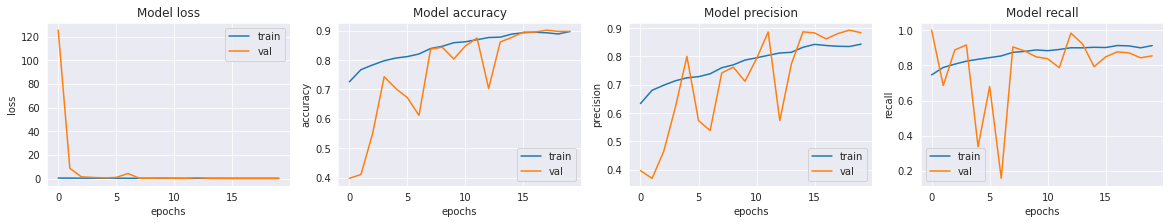

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet50_pneu.history[met])
    ax[i].plot(history_resnet50_pneu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50_pneu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 64ms/step - loss: 0.2485 - accuracy: 0.9093 - precision: 0.9234 - recall: 0.8435
Loss of the model is -  0.24850520491600037
Accuracy of the model is -  90.92920422554016 %
Precision of the model is -  0.9233871102333069
Recall of the model is -  0.8434622287750244


## ResNet50V2 - pneu lr
[Paper V1](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)
[Paper V2](https://scholar.google.com/scholar?cluster=14035416619237709781&hl=en&as_sdt=0,5)

### Model definition

Transfer learning: initalize with weights pretrained on ImageNet

In [ ]:
def resnet50_pneu_lr_builder():
    # load pretrained ResNet50V2 (ImageNet) without output
    resnet50 = ResNet50V2(include_top = False,
                          weights = None,
                          input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),)
    
    # make layers trainable
    resnet50.trainable = True
    
    model = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        resnet50, # add pretrained resnet layers to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ], name='ResNet50V2-pneu-lr')
    
    return model

In [ ]:
resnet50_pneu_lr = resnet50_pneu_lr_builder()

# load weights from pneumonia pretraining
resnet50_pneu_lr.load_weights(weights_path+'resnet50_relu_public_weights.h5')

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

resnet50_pneu_lr.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
resnet50_pneu_lr.summary()

Model: "ResNet50V2-pneu-lr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_10 (ModuleWra (None, 8, 8, 2048)        23564800  
_________________________________________________________________
AvgPool (GlobalAveragePoolin (None, 2048)              0         
_________________________________________________________________
Output (Dense)               (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
history_resnet50_pneu_lr = resnet50_pneu_lr.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks = [learning_rate_decay],
)

Epoch 1/20
226/226 [==============================] - 105s 436ms/step - loss: 0.7951 - accuracy: 0.6788 - precision: 0.5757 - recall: 0.7858 - val_loss: 0.5936 - val_accuracy: 0.7321 - val_precision: 0.6883 - val_recall: 0.5955
Epoch 2/20
226/226 [==============================] - 99s 439ms/step - loss: 0.5546 - accuracy: 0.7317 - precision: 0.6417 - recall: 0.7594 - val_loss: 0.6175 - val_accuracy: 0.6875 - val_precision: 0.6939 - val_recall: 0.3820
Epoch 3/20
226/226 [==============================] - 99s 440ms/step - loss: 0.4954 - accuracy: 0.7579 - precision: 0.6739 - recall: 0.7821 - val_loss: 0.5919 - val_accuracy: 0.7188 - val_precision: 0.7826 - val_recall: 0.4045
Epoch 4/20
226/226 [==============================] - 98s 434ms/step - loss: 0.4655 - accuracy: 0.7699 - precision: 0.6897 - recall: 0.7952 - val_loss: 0.8272 - val_accuracy: 0.6964 - val_precision: 0.8889 - val_recall: 0.2697
Epoch 5/20
226/226 [==============================] - 98s 433ms/step - loss: 0.4357 - accur

### Evaluation

###### Visualize performance

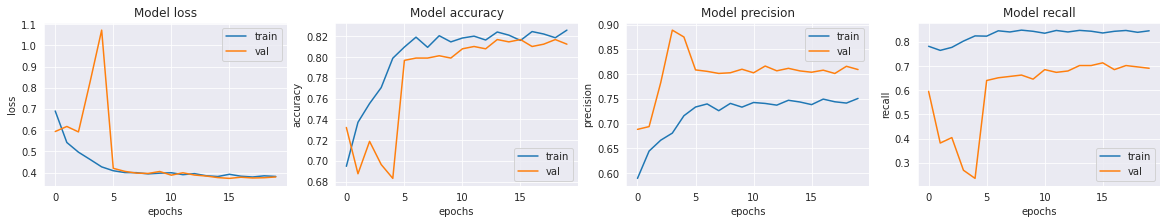

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_resnet50_pneu_lr.history[met])
    ax[i].plot(history_resnet50_pneu_lr.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = resnet50_pneu_lr.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 65ms/step - loss: 0.3615 - accuracy: 0.8392 - precision: 0.8407 - recall: 0.7385
Loss of the model is -  0.3614640235900879
Accuracy of the model is -  83.92330408096313 %
Precision of the model is -  0.8406708836555481
Recall of the model is -  0.7384898662567139


## Evaluation

In [ ]:
models = [resnet50,
          resnet50_lr,
          resnet50_noimgnet,
          resnet50_pneu,
          resnet50_pneu_lr,
]

### Model Analysis

In [ ]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating ResNet50V2 ...
43/43 [==============================] - 3s 64ms/step - loss: 0.1052 - accuracy: 0.9624 - precision: 0.9457 - recall: 0.9613


Evaluating ResNet50V2-lr ...
43/43 [==============================] - 3s 64ms/step - loss: 0.0511 - accuracy: 0.9860 - precision: 0.9852 - recall: 0.9797


Evaluating ResNet50V2-noimgnet ...
43/43 [==============================] - 3s 65ms/step - loss: 0.2188 - accuracy: 0.9130 - precision: 0.9002 - recall: 0.8803


Evaluating ResNet50V2-pneu ...
43/43 [==============================] - 3s 65ms/step - loss: 0.2485 - accuracy: 0.9093 - precision: 0.9234 - recall: 0.8435


Evaluating ResNet50V2-pneu-lr ...
43/43 [==============================] - 3s 65ms/step - loss: 0.3615 - accuracy: 0.8392 - precision: 0.8407 - recall: 0.7385




### Privacy Analysis

#### Compute epsilon

In [ ]:
# no noise added here
NOISE_MULTIPLIER = 0.0

In [ ]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [ ]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = inf


#### Membership Inference Attack

In [ ]:
def compute_attack_inputs(attack_data):
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant
    # get labels
    labels = []
    for x, y in attack_data.as_numpy_iterator():
        labels.append(y[0])
    # predict
    probs = model.predict(attack_data)
    # compute loss
    losses = np.array([x[0] for x in bc(constant([[y] for y in labels]), constant(probs), from_logits=False).numpy()])
    
    return (np.array(probs), np.array(losses), np.array(labels))

# run membership inference attack
def run_mia(model, train_attack_input, test_attack_input):
    # prepare attacks
    probs_train, loss_train, labels_train = train_attack_input
    probs_test, loss_test, labels_test = test_attack_input

    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = labels_train,
        labels_test = labels_test
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
        by_classification_correctness = True
    )

    attack_types = [
        #AttackType.THRESHOLD_ATTACK, # logistic was always better, so no threshold to save time
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    #plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    #plt.show()

    # print a user-friendly summary of the attacks
    #print(attacks_result.summary(by_slices=False))

    max_auc = attacks_result.get_result_with_max_auc().get_auc()
    max_adv = attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

    return max_auc, max_adv

# epsilon estimation based on attack, metric adapted for AUC from https://paperswithcode.com/paper/antipodes-of-label-differential-privacy-pate
def empirical_eps(auc):
    if auc <= 0.5:
        return 0
    if auc == 1:
        return np.inf
    return np.log(auc / (1 - auc))

from contextlib import contextmanager
import sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
import scipy.stats as st

for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    SAMPLE_NB = 100
    
    train_attack_input = compute_attack_inputs(train_attack_data)
    test_attack_input = compute_attack_inputs(test_attack_data)

    aucs = []
    advs = []
    emp_eps = []
    for i in range(SAMPLE_NB):
        with suppress_stdout():
            max_auc, max_adv = run_mia(model, train_attack_input, test_attack_input)
        aucs.append(max_auc)
        advs.append(max_adv)
        emp_eps.append(empirical_eps(max_auc))

    auc_low, auc_high = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
    adv_low, adv_high = st.t.interval(0.95, len(advs)-1, loc=np.mean(advs), scale=st.sem(advs))
    eps_low, eps_high = st.t.interval(0.95, len(emp_eps)-1, loc=np.mean(emp_eps), scale=st.sem(emp_eps))

    print('95%%-CI based on %i attack samples'%(SAMPLE_NB))
    print('AUC: %0.2f-%0.2f'%(auc_low, auc_high))
    print('Attacker advantage: %0.2f-%0.2f'%(adv_low, adv_high))
    print('Empirical epsilon bounds from AUC: %0.2f-%0.2f\n'%(eps_low, eps_high))

Membership Inference Attack on ResNet50V2...
95%-CI based on 100 attack samples
AUC: 0.53-0.53
Attacker advantage: 0.11-0.12
Empirical epsilon bounds from AUC: 0.10-0.13

Membership Inference Attack on ResNet50V2-lr...
95%-CI based on 100 attack samples
AUC: 0.53-0.53
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.10-0.13

Membership Inference Attack on ResNet50V2-noimgnet...
95%-CI based on 100 attack samples
AUC: 0.52-0.53
Attacker advantage: 0.11-0.12
Empirical epsilon bounds from AUC: 0.10-0.13

Membership Inference Attack on ResNet50V2-pneu...
95%-CI based on 100 attack samples
AUC: 0.52-0.53
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.10-0.13

Membership Inference Attack on ResNet50V2-pneu-lr...
95%-CI based on 100 attack samples
AUC: 0.53-0.53
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.11-0.14

